In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [4]:
twitter_analysis = pd.read_csv('Twitter Analysis.csv')
truth_seeker = pd.read_csv('Truth_Seeker_Model_Dataset.csv')

In [5]:
truth_seeker = truth_seeker[['tweet', '5_label_majority_answer']]
merged = pd.merge(twitter_analysis, truth_seeker, on='tweet', how='inner')

In [6]:
for column in merged.columns:
    print(column, merged[column].isnull().sum())

Unnamed: 0 0
majority_target 0
statement 0
BinaryNumTarget 0
tweet 0
followers_count 0
friends_count 0
favourites_count 0
statuses_count 0
listed_count 0
following 0
embeddings 0
BotScore 0
BotScoreBinary 0
cred 0
normalize_influence 0
mentions 0
quotes 0
replies 0
retweets 0
favourites 0
hashtags 0
URLs 0
unique_count 0
total_count 0
ORG_percentage 0
NORP_percentage 0
GPE_percentage 0
PERSON_percentage 0
MONEY_percentage 0
DATE_percentage 0
CARDINAL_percentage 0
PERCENT_percentage 0
ORDINAL_percentage 0
FAC_percentage 0
LAW_percentage 0
PRODUCT_percentage 0
EVENT_percentage 0
TIME_percentage 0
LOC_percentage 0
WORK_OF_ART_percentage 0
QUANTITY_percentage 0
LANGUAGE_percentage 0
Word count 0
Max word length 0
Min word length 0
Average word length 0
present_verbs 0
past_verbs 0
adjectives 0
adverbs 0
adpositions 0
pronouns 0
TOs 0
determiners 0
conjunctions 0
dots 0
exclamation 0
questions 0
ampersand 0
capitals 0
digits 0
long_word_freq 0
short_word_freq 0
5_label_majority_answer 0


In [7]:
twitter_analysis_0 = merged[merged['BotScoreBinary'] == 0].sample(n=30000, random_state=1)
twitter_analysis = merged.drop(twitter_analysis_0.index)

In [8]:
var_to_remove = ['cred', 'BinaryNumTarget', 'majority_target', 'embeddings','Max word length','Min word length', 'determiners','following', 'BotScore', 'normalize_influence', 'unique_count', 'total_count', 'ORG_percentage', 'NORP_percentage', 'DATE_percentage', 'CARDINAL_percentage','PERSON_percentage','MONEY_percentage', 'PERCENT_percentage', 'FAC_percentage', 'ORDINAL_percentage', 'LAW_percentage','DATE_percentage', 'PRODUCT_percentage', 'EVENT_percentage', 'LOC_percentage', 'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage', 'long_word_freq', 'short_word_freq', 'favourites', 'URLs', 'TIME_percentage',"TOs", 'GPE_percentage']
twitter_analysis = twitter_analysis.drop(var_to_remove, axis=1)

In [9]:
twitter_analysis['length'] = twitter_analysis['tweet'].apply(len)

In [10]:
twitter_analysis['symbols_percent'] = (twitter_analysis['dots'] + twitter_analysis['exclamation'] + twitter_analysis['questions'] + twitter_analysis['ampersand'])/twitter_analysis['length']
twitter_analysis = twitter_analysis.drop(['dots', 'exclamation', 'questions', 'ampersand'], axis=1)

In [11]:
twitter_analysis = twitter_analysis.drop('Unnamed: 0', axis=1)

In [12]:
twitter_analysis.columns

Index(['statement', 'tweet', 'followers_count', 'friends_count',
       'favourites_count', 'statuses_count', 'listed_count', 'BotScoreBinary',
       'mentions', 'quotes', 'replies', 'retweets', 'hashtags', 'Word count',
       'Average word length', 'present_verbs', 'past_verbs', 'adjectives',
       'adverbs', 'adpositions', 'pronouns', 'conjunctions', 'capitals',
       'digits', '5_label_majority_answer', 'length', 'symbols_percent'],
      dtype='object')

In [13]:
twitter_analysis_original = twitter_analysis.copy()

# Metrics

## Reputation Score

range: [1;+inf]. 

How much importance the user has in the community.  The reputation score is calculated using the following formula:
weighted average of the favorite count, status count, and quotes of the user.

Problem: quotes is highly skewed, distribution. We will convert into a binary variable, 1 if the user has quotes, 0 otherwise.

In [14]:
twitter_analysis['quotes'].describe()

count    104198.000000
mean          0.535164
std          25.372243
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        5498.000000
Name: quotes, dtype: float64

In [15]:
twitter_analysis['quotes_bin'] = 0
twitter_analysis.loc[twitter_analysis['quotes'] != 0, 'quotes_bin'] = 1

Apply log transformation to the favorite count and status count to reduce the skewness.

In [16]:
twitter_analysis['favourites_count'].describe()

count    1.041980e+05
mean     3.259701e+04
std      6.832905e+04
min      0.000000e+00
25%      1.261000e+03
50%      8.157000e+03
75%      3.309475e+04
max      1.765080e+06
Name: favourites_count, dtype: float64

In [17]:
twitter_analysis['favourites_count'] = np.log(twitter_analysis['favourites_count'] + 1)

status count

In [18]:
twitter_analysis['statuses_count'].describe()

count    1.041980e+05
mean     3.386297e+04
std      7.493044e+04
min      1.000000e+00
25%      2.957000e+03
50%      1.085800e+04
75%      3.331250e+04
max      2.958918e+06
Name: statuses_count, dtype: float64

In [19]:
twitter_analysis['statuses_count'] = np.log(twitter_analysis['statuses_count'] + 1)

Computation of the reputation score

In [20]:
twitter_analysis['favourites_count'] = (twitter_analysis['favourites_count'] - twitter_analysis['favourites_count'].min())/(twitter_analysis['favourites_count'].max() - twitter_analysis['favourites_count'].min())
twitter_analysis['statuses_count'] = (twitter_analysis['statuses_count'] - twitter_analysis['statuses_count'].min())/(twitter_analysis['statuses_count'].max() - twitter_analysis['statuses_count'].min())

In [21]:
weight_favourites = 0.3
weight_quotes = 0.4
weight_statuses = 0.3

twitter_analysis['reputation_score'] = 1 + 500*(weight_favourites * twitter_analysis['favourites_count']) + (weight_quotes * twitter_analysis['quotes_bin']+weight_statuses * twitter_analysis['statuses_count'])

In [22]:
twitter_analysis.reputation_score.describe()

count    104198.000000
mean         89.526261
std          28.349646
min           1.000000
25%          75.641277
50%          95.118484
75%         109.750435
max         151.214992
Name: reputation_score, dtype: float64

In [23]:
twitter_analysis_0 = twitter_analysis[twitter_analysis['BotScoreBinary'] == 1].sample(n=400, random_state=1)
twitter_analysis_1 = twitter_analysis[twitter_analysis['BotScoreBinary'] == 0].sample(n=9600, random_state=1)

twitter_analysis_mini = pd.concat([twitter_analysis_0, twitter_analysis_1])

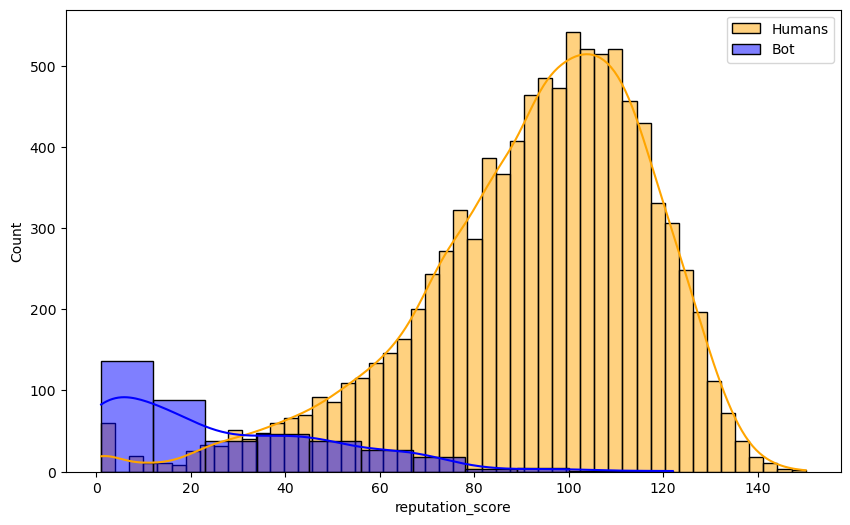

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(twitter_analysis_mini[twitter_analysis_mini['BotScoreBinary'] == 0]['reputation_score'], label='Humans', kde=True, color='orange')
sns.histplot(twitter_analysis_mini[twitter_analysis_mini['BotScoreBinary'] == 1]['reputation_score'], label='Bot', kde=True, color='blue')
plt.legend()

## Post Confidence Score

Assuming a normal distribution for both bot and humans, we can create the confidence score of a post by using a normal distribution around 0.75 and deviation of 0.1.

Bots typically operate based on algorithms and rules rather than human intuition or subjective judgment. Therefore, a distribution with a lower mean and higher standard deviation might be appropriate to reflect this uncertainty.

In [25]:
twitter_analysis['post_confidence_score'] = np.where(twitter_analysis['BotScoreBinary'] == 0,
                                                      np.random.normal(0.75, 0.1, twitter_analysis.shape[0]),
                                                      np.random.normal(0.65, 0.2, twitter_analysis.shape[0]))

min_score = twitter_analysis['post_confidence_score'].min()
max_score = twitter_analysis['post_confidence_score'].max()
twitter_analysis['post_confidence_score'] = 0.5 + (twitter_analysis['post_confidence_score'] - min_score) * (0.5 / (max_score - min_score))
twitter_analysis['post_confidence_score'] = twitter_analysis['post_confidence_score'].clip(0.5, 1)

In [26]:
twitter_analysis.post_confidence_score.describe()

count    104198.000000
mean          0.768514
std           0.035165
min           0.500000
25%           0.746308
50%           0.769280
75%           0.791694
max           1.000000
Name: post_confidence_score, dtype: float64

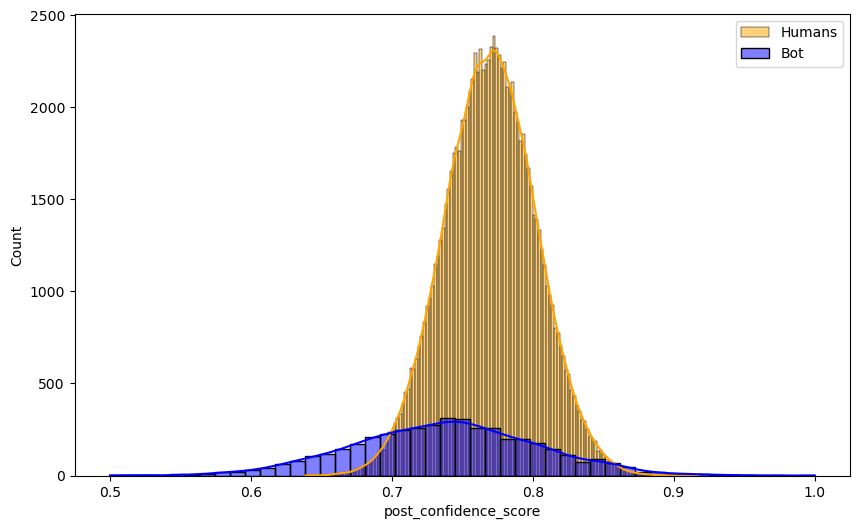

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 0]['post_confidence_score'], label='Humans', kde=True, color='orange')
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 1]['post_confidence_score'], label='Bot', kde=True, color='blue')
plt.legend()

## Influence Score

The influence score reflects the impact of the user in the community. It is calculated using the ratio bewteen the number of followers and the number of friends of the user.

In [28]:
twitter_analysis.columns

Index(['statement', 'tweet', 'followers_count', 'friends_count',
       'favourites_count', 'statuses_count', 'listed_count', 'BotScoreBinary',
       'mentions', 'quotes', 'replies', 'retweets', 'hashtags', 'Word count',
       'Average word length', 'present_verbs', 'past_verbs', 'adjectives',
       'adverbs', 'adpositions', 'pronouns', 'conjunctions', 'capitals',
       'digits', '5_label_majority_answer', 'length', 'symbols_percent',
       'quotes_bin', 'reputation_score', 'post_confidence_score'],
      dtype='object')

In [29]:
twitter_analysis['followers_count'] = np.log(twitter_analysis['followers_count'] + 1)
twitter_analysis['followers_count'].describe()

count    104198.000000
mean          5.751096
std           2.376441
min           0.000000
25%           4.219508
50%           5.846439
75%           7.344073
max          18.687664
Name: followers_count, dtype: float64

In [30]:
twitter_analysis['friends_count'] = np.log(twitter_analysis['friends_count'] + 1)
twitter_analysis['friends_count'].describe()

count    104198.000000
mean          6.146481
std           1.860435
min           0.000000
25%           5.087596
50%           6.318968
75%           7.438972
max          13.282613
Name: friends_count, dtype: float64

In [31]:
weight_followers = 0.7
weight_friends = 0.3

twitter_analysis['influence_score'] = weight_followers * twitter_analysis['followers_count'] + weight_friends * twitter_analysis['friends_count']
twitter_analysis['influence_score'] = (twitter_analysis['influence_score'] - twitter_analysis['influence_score'].min())/(twitter_analysis['influence_score'].max() - twitter_analysis['influence_score'].min()

In [32]:
twitter_analysis['influence_score'].describe()

count    104198.000000
mean          0.343939
std           0.124695
min           0.000000
25%           0.263689
50%           0.349906
75%           0.431133
max           1.000000
Name: influence_score, dtype: float64

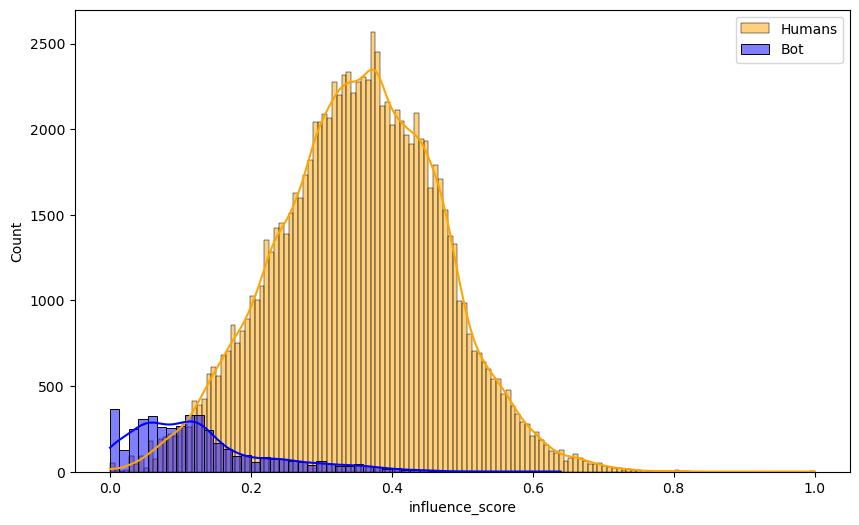

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 0]['influence_score'], label='Humans', kde=True, color='orange')
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 1]['influence_score'], label='Bot', kde=True, color='blue')
plt.legend()

## Changing in Voting Impact

Voting Impact is affected by the confidence score and the reputation score and the number of upvotes/downvotes.

### Upvotes / Downvotes

In [34]:
twitter_analysis['5_label_majority_answer'].value_counts()

Agree              42081
Mostly Agree       41827
NO MAJORITY        17626
Mostly Disagree     2239
Disagree             425
Name: 5_label_majority_answer, dtype: int64

map the majority label upvotes and downvotes to a range of [-1;1] 

In [35]:
sentiment_mapping = {
    'Agree': 1,
    'Mostly Agree': 0.5,
    'NO MAJORITY': 0,
    'Mostly Disagree': -0.5,
    'Disagree': -1
}

twitter_analysis['votes'] = twitter_analysis['5_label_majority_answer'].map(sentiment_mapping)

In [36]:
twitter_analysis['votes'].value_counts()

 1.0    42081
 0.5    41827
 0.0    17626
-0.5     2239
-1.0      425
Name: votes, dtype: int64

Calculating Change in Voting Impact

In [37]:
twitter_analysis['change_in_voting_impact'] = twitter_analysis['votes'] * twitter_analysis['reputation_score'] * twitter_analysis['post_confidence_score']

In [38]:
twitter_analysis['change_in_voting_impact'].describe()

count    104198.000000
mean         40.606178
std          32.171376
min        -115.014680
25%          18.868044
50%          39.950071
75%          66.841736
max         124.251824
Name: change_in_voting_impact, dtype: float64

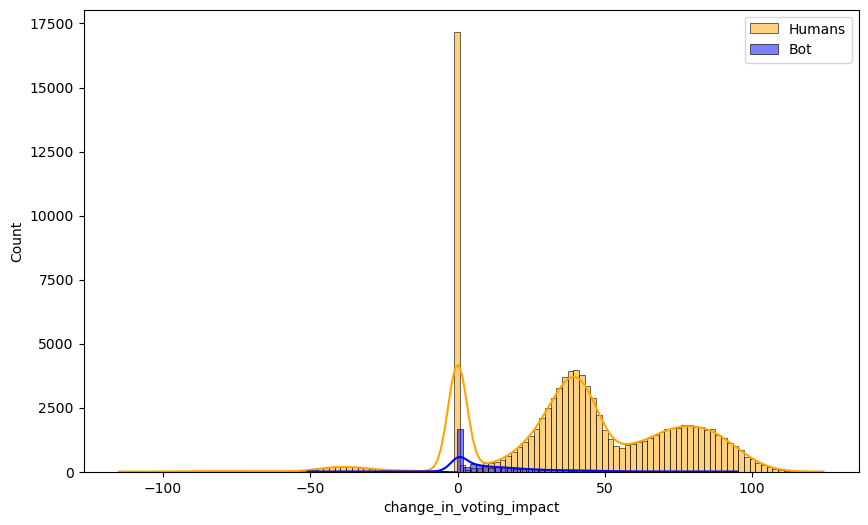

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 0]['change_in_voting_impact'], label='Humans', kde=True, color='orange')
sns.histplot(twitter_analysis[twitter_analysis['BotScoreBinary'] == 1]['change_in_voting_impact'], label='Bot', kde=True, color='blue')
plt.legend()

## Other variables

In [40]:
twitter_analysis['listed_count'] = np.log(twitter_analysis['listed_count'] + 1)
twitter_analysis['listed_count'].describe()

count    104198.000000
mean          1.570033
std           1.765237
min           0.000000
25%           0.000000
50%           1.098612
75%           2.484907
max          12.311306
Name: listed_count, dtype: float64

In [41]:
twitter_analysis['mentions'] = np.log(twitter_analysis['mentions'] + 1)
twitter_analysis['mentions'].describe()

count    104198.000000
mean          0.709680
std           0.558261
min           0.000000
25%           0.000000
50%           0.693147
75%           1.098612
max           2.564949
Name: mentions, dtype: float64

In [42]:
twitter_analysis['replies'] = np.log(twitter_analysis['replies'] + 1)
twitter_analysis['replies'].describe()

count    104198.000000
mean          0.308417
std           0.567036
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           8.821290
Name: replies, dtype: float64

In [43]:
twitter_analysis['retweets'] = np.log(twitter_analysis['retweets'] + 1)
twitter_analysis['retweets'].describe()


count    104198.000000
mean          0.223258
std           0.697791
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.744537
Name: retweets, dtype: float64

In [44]:
twitter_analysis['hashtags'] = np.log(twitter_analysis['hashtags'] + 1)
twitter_analysis['hashtags'].describe()

count    104198.000000
mean          0.060406
std           0.232802
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.564949
Name: hashtags, dtype: float64

In [45]:
twitter_analysis['verbs'] = twitter_analysis['present_verbs'] + twitter_analysis['past_verbs']
twitter_analysis = twitter_analysis.drop(['present_verbs', 'past_verbs'], axis=1)

In [46]:
twitter_analysis['adj_pron'] = twitter_analysis['adjectives'] + twitter_analysis['pronouns']
twitter_analysis = twitter_analysis.drop(['adjectives', 'pronouns'], axis=1)

In [47]:
twitter_analysis['adpo_conj'] = twitter_analysis['adpositions'] + twitter_analysis['conjunctions']
twitter_analysis = twitter_analysis.drop(['adpositions', 'conjunctions'], axis=1)

# Supervised Learning

Dataset Preparation

In [48]:
twitter_analysis.columns

Index(['statement', 'tweet', 'followers_count', 'friends_count',
       'favourites_count', 'statuses_count', 'listed_count', 'BotScoreBinary',
       'mentions', 'quotes', 'replies', 'retweets', 'hashtags', 'Word count',
       'Average word length', 'adverbs', 'capitals', 'digits',
       '5_label_majority_answer', 'length', 'symbols_percent', 'quotes_bin',
       'reputation_score', 'post_confidence_score', 'influence_score', 'votes',
       'change_in_voting_impact', 'verbs', 'adj_pron', 'adpo_conj'],
      dtype='object')

In [49]:
vars_to_remove = ['statement', 'tweet', 'followers_count', 'friends_count', '5_label_majority_answer', 'quotes']
twitter_analysis_algo = twitter_analysis.drop(vars_to_remove, axis=1)

In [50]:
twitter_analysis_algo.columns

Index(['favourites_count', 'statuses_count', 'listed_count', 'BotScoreBinary',
       'mentions', 'replies', 'retweets', 'hashtags', 'Word count',
       'Average word length', 'adverbs', 'capitals', 'digits', 'length',
       'symbols_percent', 'quotes_bin', 'reputation_score',
       'post_confidence_score', 'influence_score', 'votes',
       'change_in_voting_impact', 'verbs', 'adj_pron', 'adpo_conj'],
      dtype='object')

## Logistic Regression

In [51]:
twitter_analysis_lr = twitter_analysis_algo.copy()

In [52]:
y = twitter_analysis_lr['BotScoreBinary']

X = twitter_analysis_lr.drop('BotScoreBinary', axis=1)

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

In [54]:
def train_logistic_regression(X, y, test_size=0.4, random_state=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    
    accuracy_train = metrics.accuracy_score(y_train, logreg.predict(X_train))
    accuracy_test = metrics.accuracy_score(y_test, y_pred)
    
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    
    X_train_sm = sm.add_constant(X_train)  # Add constant term for intercept
    logit_model = sm.Logit(y_train, X_train_sm)
    result = logit_model.fit()
    
    print('\nSummary of Logistic Regression:')
    print(result.summary())
    
    return accuracy_train, accuracy_test, roc_auc


accuracy_train_lr, accuracy_test_lr, roc_auc_lr = train_logistic_regression(X, y)
print('Accuracy train:', accuracy_train_lr)
print('Accuracy test:', accuracy_test_lr)
print('AUC:', roc_auc_lr)


/Users/dimonopoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[39557   386]
 [  889   848]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     39943
         1.0       0.69      0.49      0.57      1737

    accuracy                           0.97     41680
   macro avg       0.83      0.74      0.78     41680
weighted avg       0.97      0.97      0.97     41680

Optimization terminated successfully.
         Current function value: 0.065328
         Iterations 11

Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:         BotScoreBinary   No. Observations:                62518
Model:                          Logit   Df Residuals:                    62494
Method:                           MLE   Df Model:                           23
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                  0.6228
Time:                        22:49:38   Log-Likelihood:            

## PCA + SVM

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVC

def train_svm_with_lasso(X, y, test_size=0.3, random_state=1, alpha=0.001):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    selected_features = np.where(lasso.coef_ != 0)[0]
    
    print("Selected Features by Lasso:")
    print(', '.join([str(feature) for feature in selected_features]))
    
    svm = SVC(kernel='linear', probability=True)  # Use linear kernel for interpretability
    svm.fit(X_train.iloc[:, selected_features], y_train)  # Adjusted indexing for DataFrame
    
    y_pred = svm.predict(X_test.iloc[:, selected_features])  # Adjusted indexing for DataFrame
    
    accuracy_train = svm.score(X_train.iloc[:, selected_features], y_train)
    accuracy_test = svm.score(X_test.iloc[:, selected_features], y_test)
    
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, svm.predict(X_test.iloc[:, selected_features]))  # Adjusted indexing for DataFrame
    
    return accuracy_train, accuracy_test, roc_auc

accuracy_train_svm_lasso, accuracy_test_svm_lasso, roc_auc_svm_lasso = train_svm_with_lasso(X, y, alpha=0.01)
print('Accuracy train (with Lasso):', accuracy_train_svm_lasso)
print('Accuracy test (with Lasso):', accuracy_test_svm_lasso)
print('AUC (with Lasso):', roc_auc_svm_lasso)

Selected Features by Lasso:
2, 12, 15, 19


## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def train_gradient_boosting(X, y, test_size=0.4, random_state=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    gbc = GradientBoostingClassifier()
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict(X_test)
    
    accuracy_train = metrics.accuracy_score(y_train, gbc.predict(X_train))
    accuracy_test = metrics.accuracy_score(y_test, y_pred)
    
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
    
    feature_importance = gbc.feature_importances_
    sorted_idx = feature_importance.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align='center')
    plt.yticks(range(X.shape[1]), [list(X.columns)[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Gradient Boosting Classifier Feature Importance')
    plt.show()
    
    return accuracy_train, accuracy_test, roc_auc

accuracy_train_gb, accuracy_test_gb, roc_auc_gb = train_gradient_boosting(X, y)
print('Accuracy train:', accuracy_train_gb)
print('Accuracy test:', accuracy_test_gb)
print('AUC:', roc_auc_gb)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X, y, test_size=0.4, random_state=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    accuracy_train = metrics.accuracy_score(y_train, rf.predict(X_train))
    accuracy_test = metrics.accuracy_score(y_test, y_pred)
    
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, rf.predict(X_test))
    
    feature_importance = rf.feature_importances_
    sorted_idx = feature_importance.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align='center')
    plt.yticks(range(X.shape[1]), [list(X.columns)[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Classifier Feature Importance')
    plt.show()
    
    return accuracy_train, accuracy_test, roc_auc

accuracy_train_rf, accuracy_test_rf, roc_auc_rf = train_random_forest(X, y)
print('Accuracy train:', accuracy_train_rf)
print('Accuracy test:', accuracy_test_rf)
print('AUC:', roc_auc_rf)

# Benford Law

## Compute Frequencies

define a function to compute the first digit of a number

In [55]:
from scipy.stats import chisquare

def compute_frequencies(values):
    values = np.where(values == 0, 1, values)

    first_digits = [int(str(value)[0]) for value in values]
    counts = {i: first_digits.count(i) for i in range(1, 10)}

    return counts

In [56]:
bot_data = twitter_analysis_original[twitter_analysis_original['BotScoreBinary'] == 1]
human_data = twitter_analysis_original[twitter_analysis_original['BotScoreBinary'] == 0]

## Execute Benford Test

Do a chi-squared test to check if the first digit of the different feature variables follows the Benford Law.

In [57]:
def perform_chi_square_test(data, human_bot):
    observed_frequencies = compute_frequencies(data)

    column_name = data.name

    total_count = sum(observed_frequencies.values())
    expected_frequencies = {digit: total_count * np.log10(1 + 1/digit) for digit in range(1, 10)}
    
    observed = np.array([observed_frequencies[digit] for digit in range(1, 10)])
    expected = np.array([expected_frequencies[digit] for digit in range(1, 10)])
    
    observed_relative = observed / np.sum(observed)
    expected_relative = expected / np.sum(expected)
    
    chi2_stat, p_value = chisquare(observed, f_exp=expected)

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(1, 10)
    
    observed_bars = ax.bar(index - bar_width/2, observed_relative, bar_width, label='Observed', color='orange')
    expected_bars = ax.bar(index + bar_width/2, expected_relative, bar_width, label='Benford Distribution', alpha=0.3)  

    for bar in observed_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom')
    
    for bar in expected_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom')

    ax.set_xlabel('First Digit')
    ax.set_ylabel('Relative Frequency')
    ax.set_title(f'FDLS Distribution for {column_name}, {human_bot}')
    ax.set_xticks(index)
    ax.legend()
    plt.show()

    fig.savefig(f'FDLS Distribution for {column_name}, {human_bot}.png')
    
    return chi2_stat, p_value

In [58]:
bot_followers = bot_data['followers_count']
human_followers = human_data['followers_count']

In [59]:
bot_friends = bot_data['friends_count']
human_friends = human_data['friends_count']

In [60]:
bot_statuses = bot_data['statuses_count']
human_statuses = human_data['statuses_count']

In [61]:
bot_favourites = bot_data['favourites_count']
human_favourites = human_data['favourites_count']

In [62]:
bot_listed = bot_data['listed_count']
human_listed = human_data['listed_count']

In [63]:
bot_mentions = bot_data['mentions']
human_mentions = human_data['mentions']

test

Bot Data:


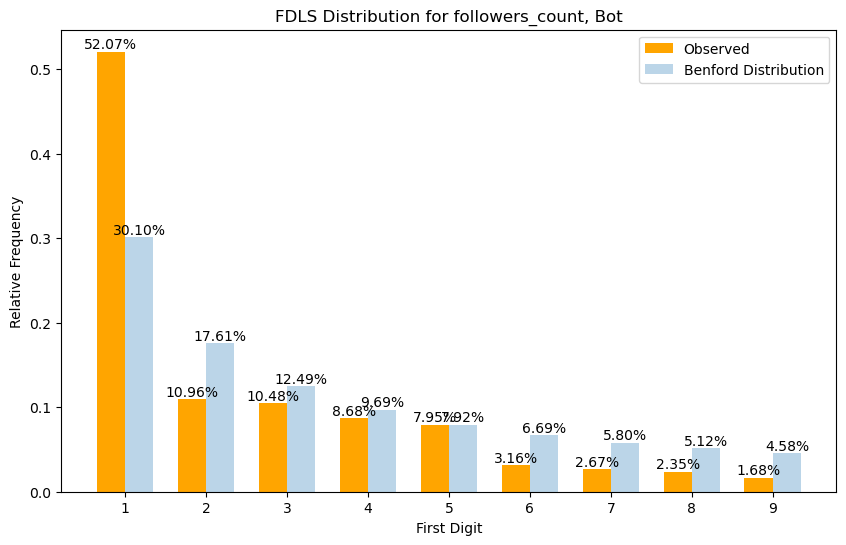


Human Data:


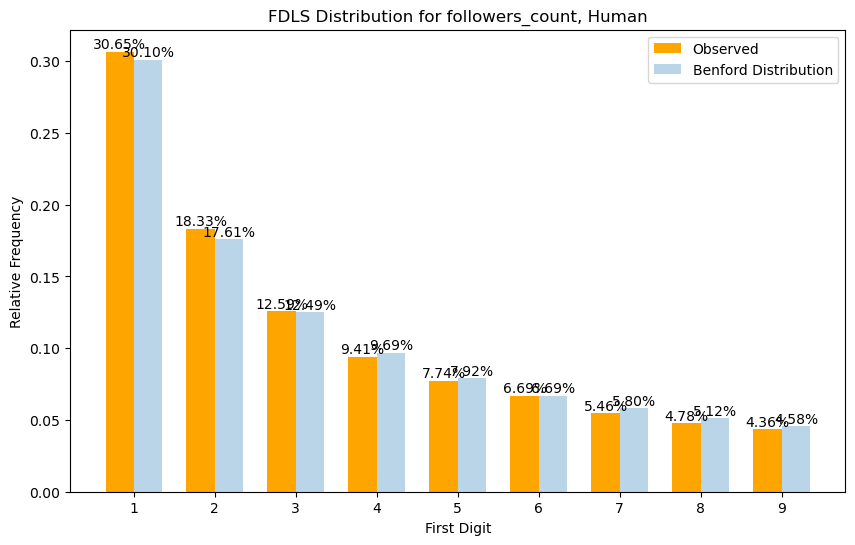

In [64]:
# Perform chi-square test for bot data
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_followers, "Bot")


# Perform chi-square test for human data
print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_followers, "Human")



Bot Data:


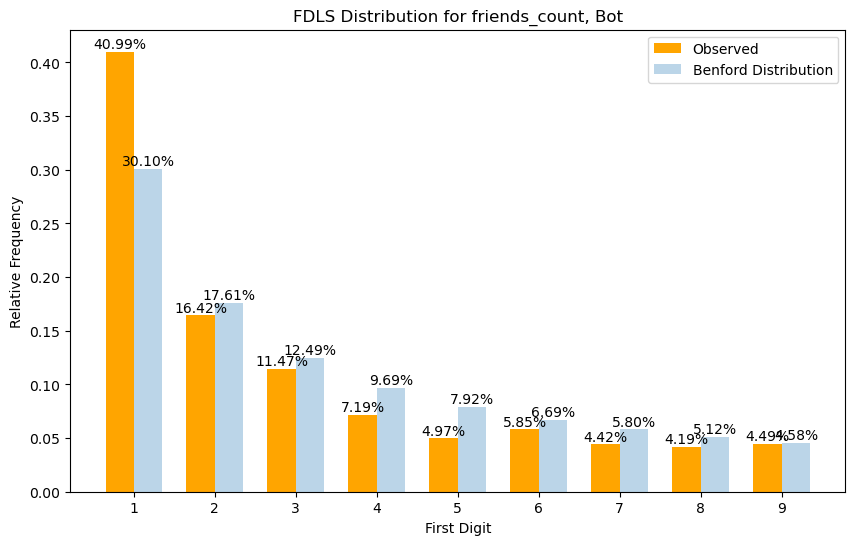


Human Data:


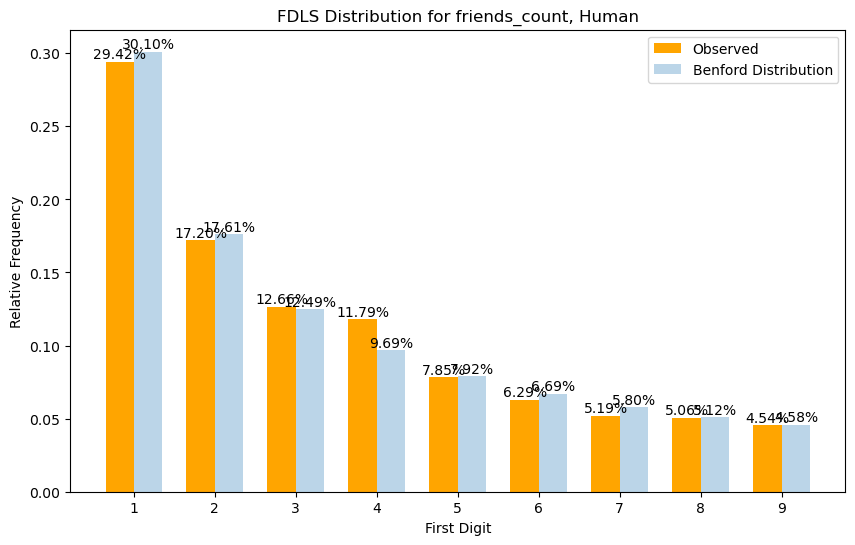

In [65]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_friends, "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_friends, "Human")

Bot Data:


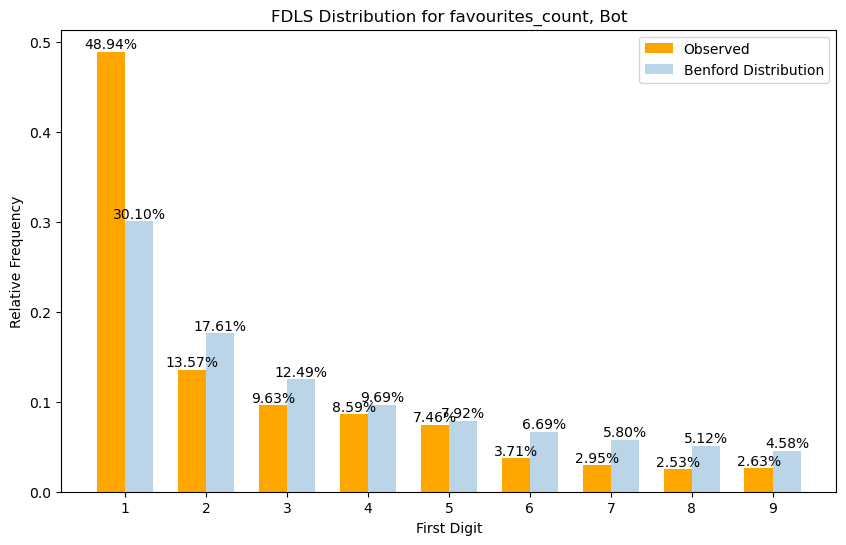


Human Data:


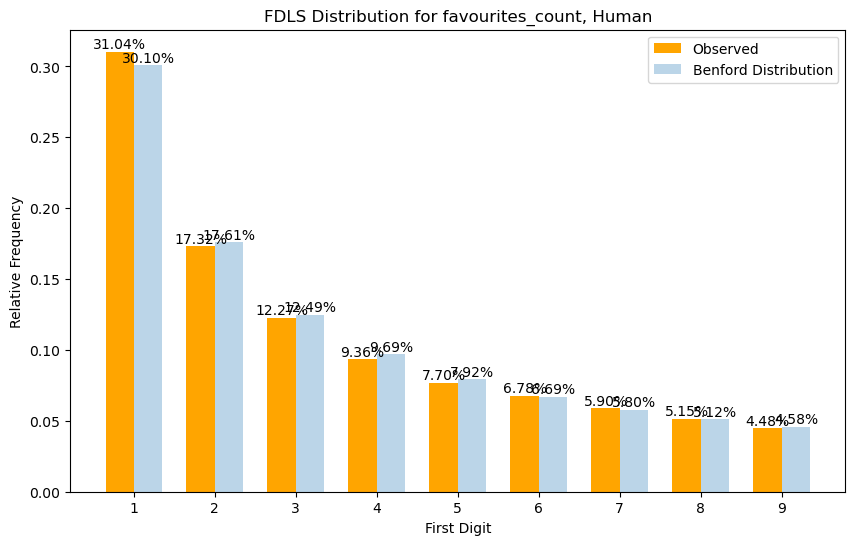

In [66]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_favourites, "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_favourites, "Human")

Bot Data:


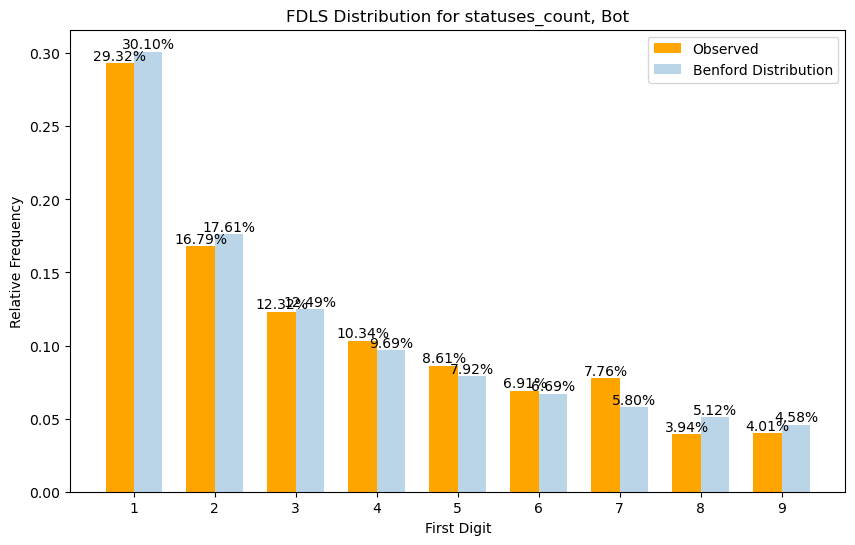


Human Data:


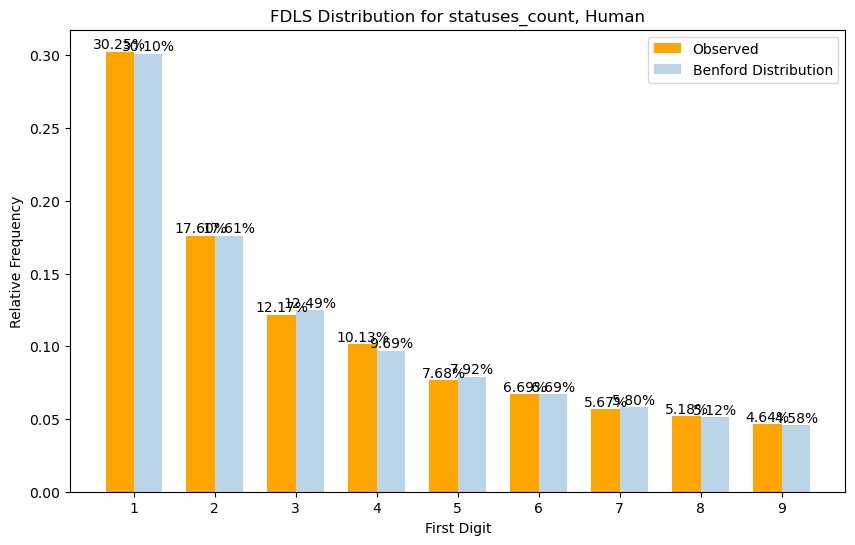

In [67]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_statuses, "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_statuses, "Human")

Bot Data:


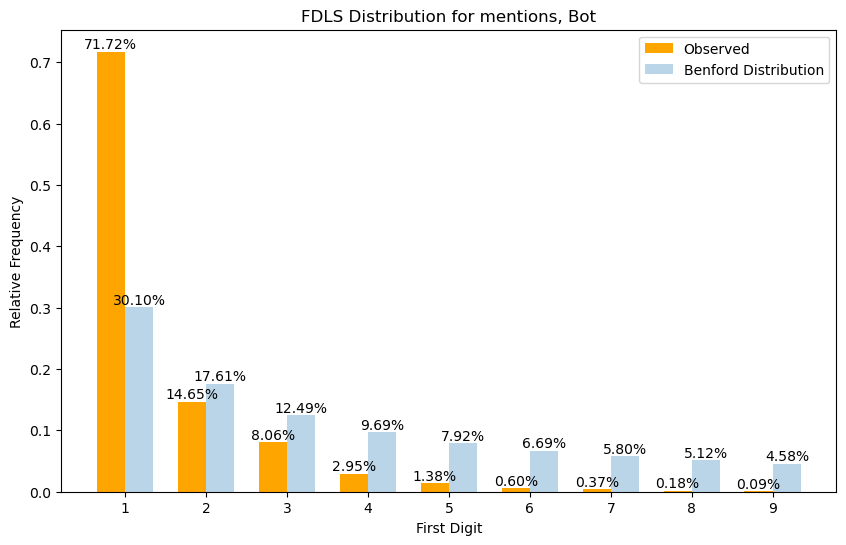


Human Data:


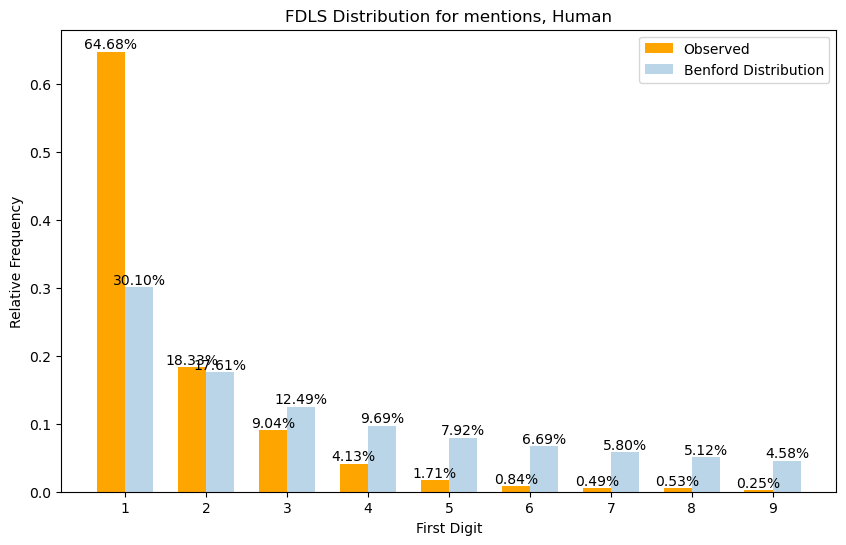

In [68]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_mentions, "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_mentions, "Human")

Bot Data:


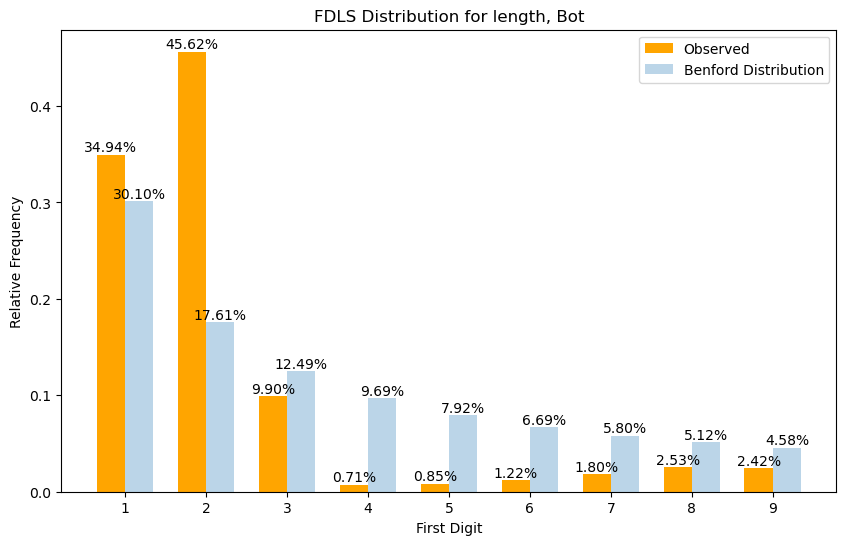


Human Data:


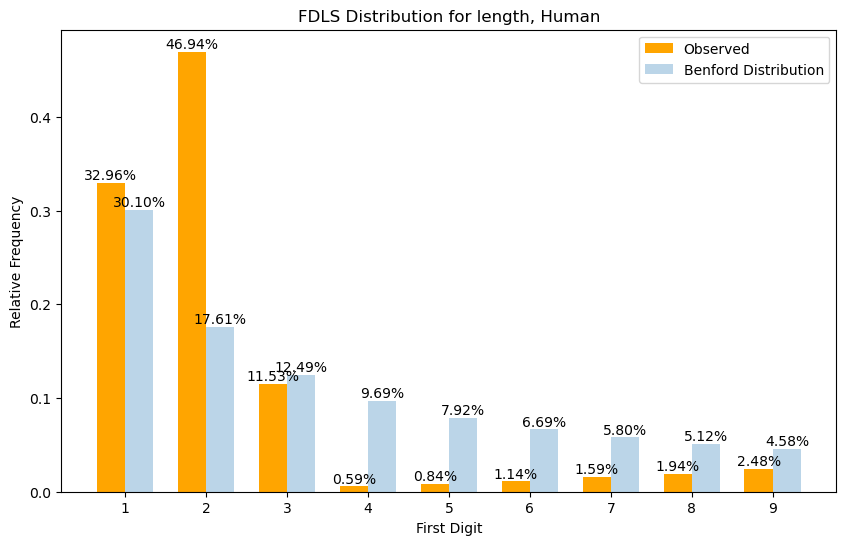

In [69]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_data['length'], "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_data['length'], "Human")

Bot Data:


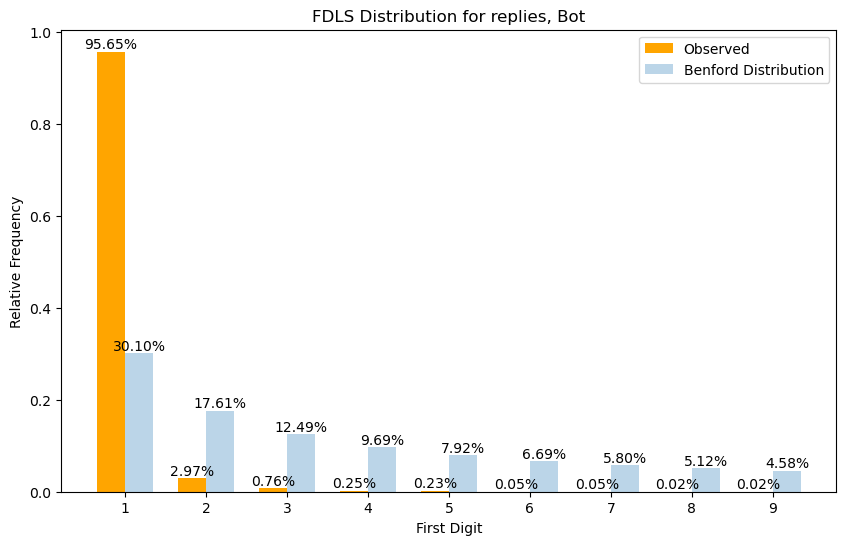


Human Data:


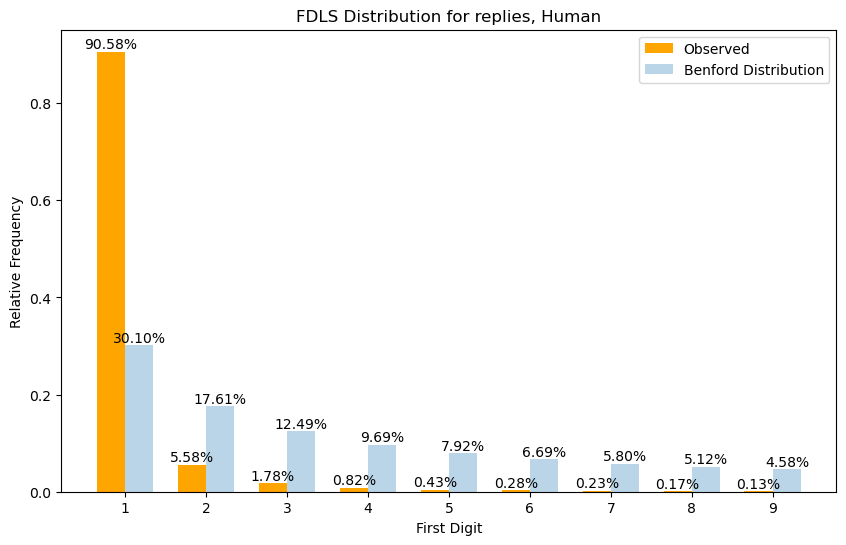

In [70]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_data['replies'], "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_data['replies'], "Human")

Bot Data:


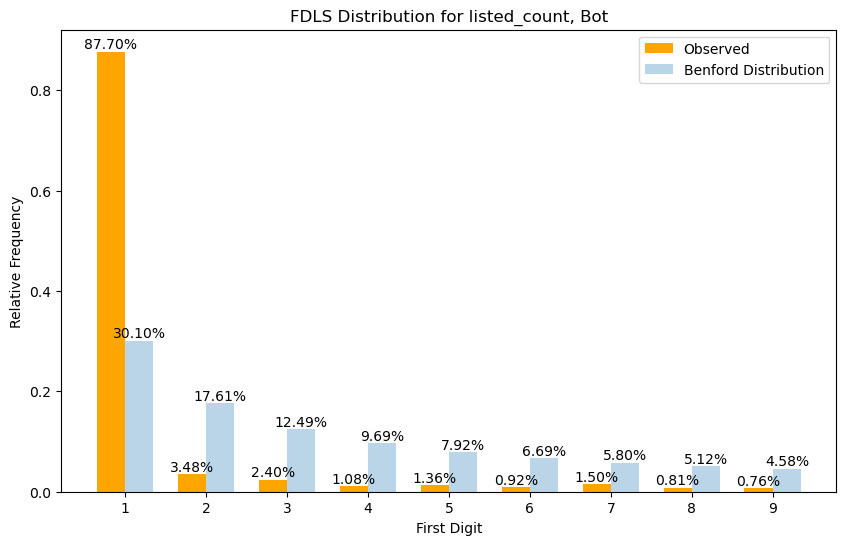


Human Data:


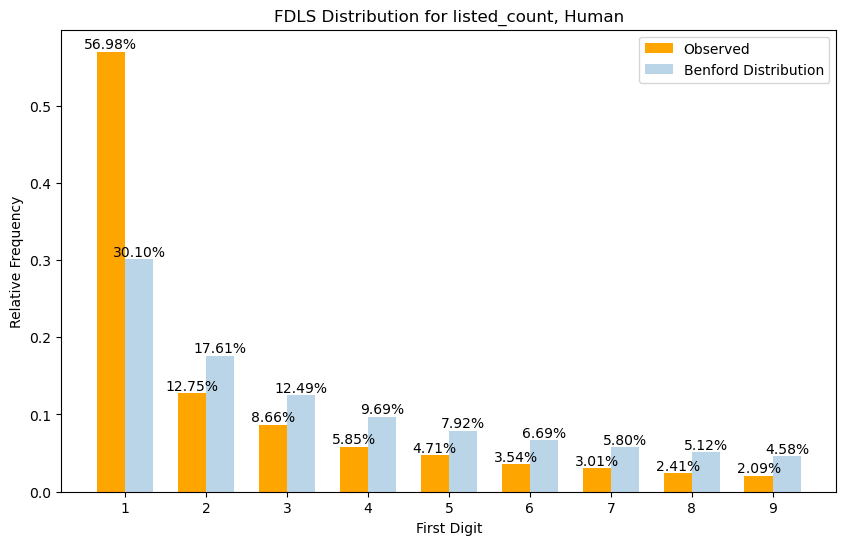

In [71]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_listed, "Bot")


print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_listed, "Human")

Bot Data:


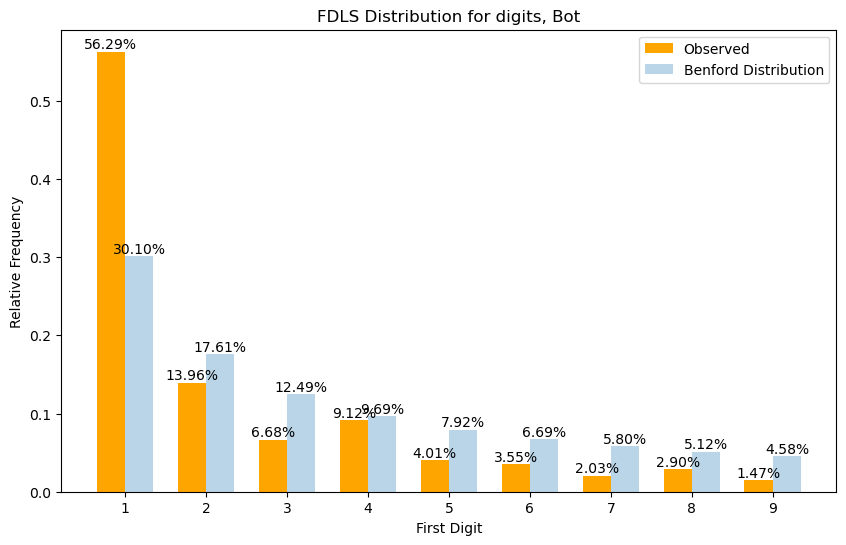


Human Data:


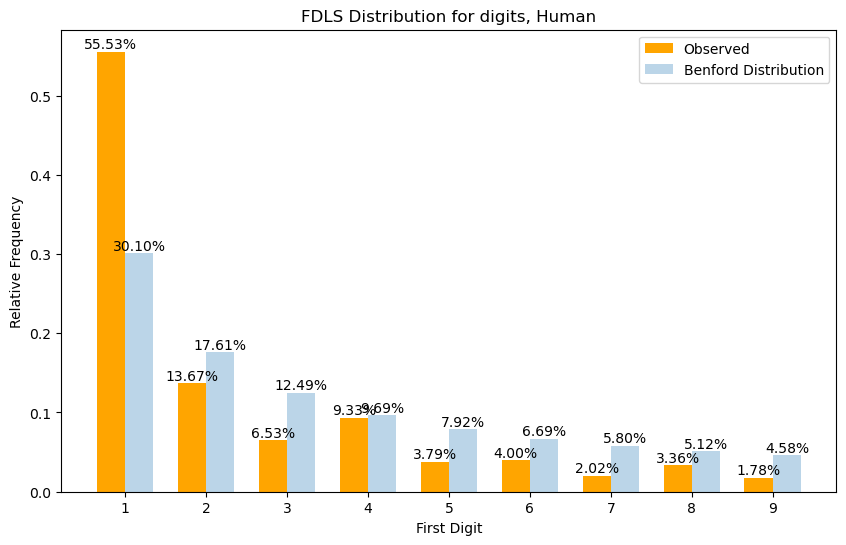

In [72]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_data['digits'], "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_data['digits'], "Human")

Bot Data:


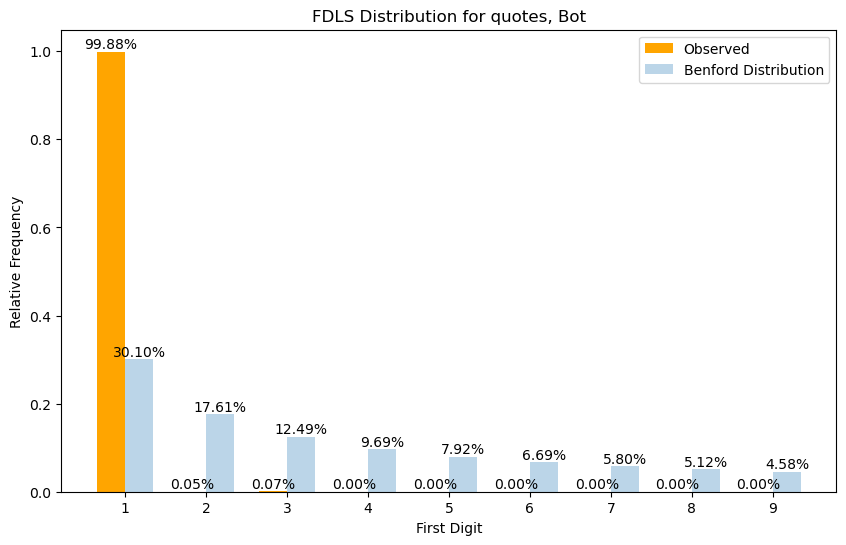


Human Data:


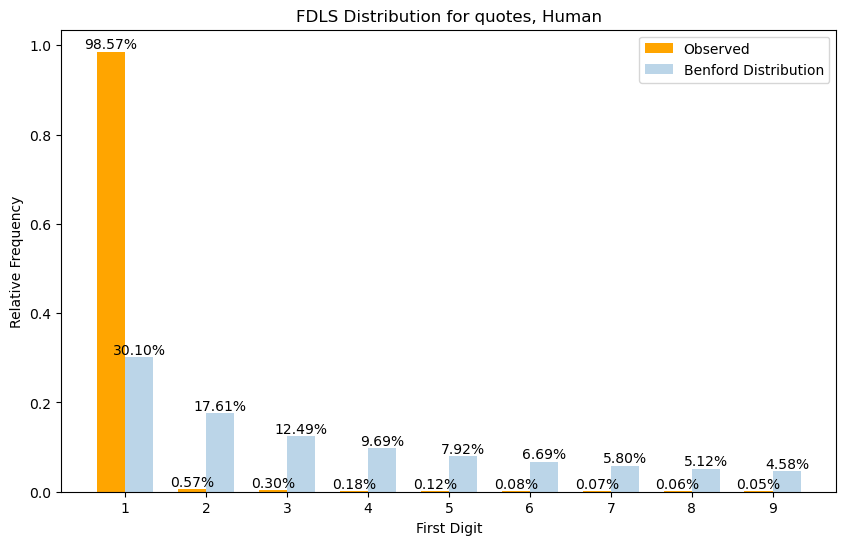

In [73]:
print("Bot Data:")
bot_chi2_stat, bot_p_value = perform_chi_square_test(bot_data['quotes'], "Bot")

print("\nHuman Data:")
human_chi2_stat, human_p_value = perform_chi_square_test(human_data['quotes'], "Human")

In [74]:
twitter_analysis.columns

Index(['statement', 'tweet', 'followers_count', 'friends_count',
       'favourites_count', 'statuses_count', 'listed_count', 'BotScoreBinary',
       'mentions', 'quotes', 'replies', 'retweets', 'hashtags', 'Word count',
       'Average word length', 'adverbs', 'capitals', 'digits',
       '5_label_majority_answer', 'length', 'symbols_percent', 'quotes_bin',
       'reputation_score', 'post_confidence_score', 'influence_score', 'votes',
       'change_in_voting_impact', 'verbs', 'adj_pron', 'adpo_conj'],
      dtype='object')

# Semi Supervised Learning

In [75]:
twitter_analysis_semi_sup = twitter_analysis.copy()

# keep only the columns that are relevant for the semi-supervised learning
twitter_analysis_semi_sup = twitter_analysis_semi_sup[['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'BotScoreBinary']]

X = twitter_analysis_semi_sup.drop(columns=['BotScoreBinary'])
y = twitter_analysis_semi_sup['BotScoreBinary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Guassian Mixture Model (GMM)

In [81]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

gmm = GaussianMixture(n_components=2)  

gmm.fit(X_train, y_train)

y_pred = gmm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.7811420345489444
Recall: 0.922722029988466
AUC: 0.8488591374595612
Precision: 0.1511144692104269
F1 Score: 0.25969810095763673


Semi-supervised SVM: SVC

In [83]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.968809980806142
Recall: 0.4786620530565167
AUC: 0.7343743349946881
Precision: 0.6769983686786297
F1 Score: 0.5608108108108107


Label Propagation

In [80]:
from sklearn.semi_supervised import LabelPropagation

label_propagation = LabelPropagation(kernel='knn', n_neighbors=10)

label_propagation.fit(X_train, y_train)

y_pred = label_propagation.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.9899232245681382
Recall: 0.8269896193771626
AUC: 0.9119927819511358
Precision: 0.9227799227799228
F1 Score: 0.8722627737226277


Label Spreading Model

In [78]:
from sklearn.semi_supervised import LabelSpreading

label_spreading = LabelSpreading(kernel='knn', n_neighbors=10, alpha=0.2)
label_spreading.fit(X_train, y_train)

y_pred = label_spreading.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Accuracy: 0.9892514395393474
Recall: 0.8362168396770473
AUC: 0.9160556485973481
Precision: 0.8983890954151177
F1 Score: 0.8661887694145759
